# Part IV -  ML For Interpersonal Physical Alignment
#####  @ Haim Goldfisher

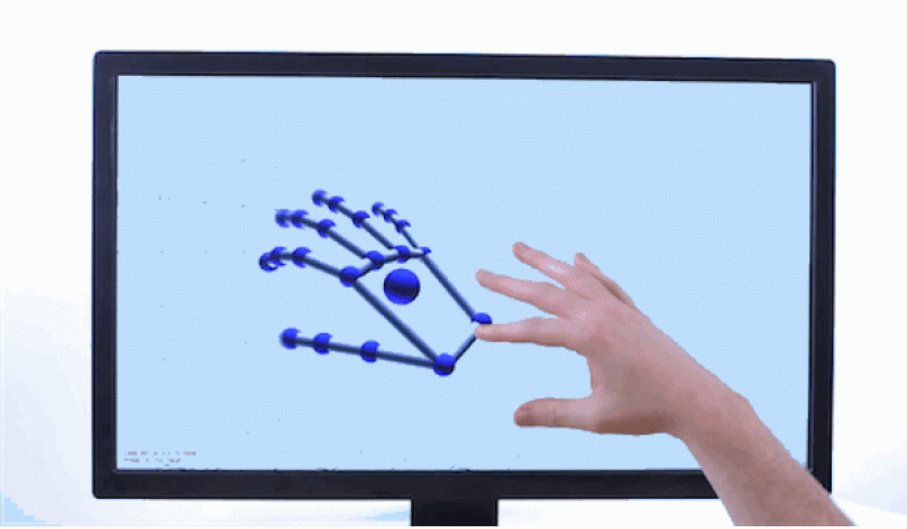

# Libraries Importation:

In [1]:
import cv2 # openCv
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#import warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Data Preprocessing:

from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,roc_curve, roc_auc_score, accuracy_score

# Models:

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier

# A model that I learned by myself: CatBoost + Plotly

from catboost import CatBoostClassifier
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px

# Clustering:

from sklearn.cluster import KMeans

# PCA:

from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import IncrementalPCA

# Scaling:

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Cross Validation:

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Brief Summary:

The purpose of the work is to classify between three different situations in the way people communicate with each other:
- The first is Spontaneous (autonomous) situation in which two people move their hands freely in front of each other.
- The second is a synchronous movement in which the two people move their hands together. 
- The third is a movement in position own (alone). Where only one side moves the hands.

The idea is to look at the patterns of the hands and try to deduce from them whether it is a situation alone, spontaneous or synchronous.

The experiment is based on synchronization between two people. That is, they both "transmit on the same wave" so that no one is leading this synchronization. In this case the argument is that there is not one "brain" of the two that leads but two brains of two people uniting into a spring of cooperation that is supposedly above both of them, which controls their movements in the synchronization process.

The experiment uses a system that captures the position of a person's hands. The system knows where the hand is. The experiment places two people facing each other. The experiment operation tells them to move their hands in front of each other spontaneously. He then asks them to be in sync (the process causes both parties to try to be in sync). People begin to perceive each other in order to understand the other side (there must be no imitation of one side, otherwise it does not work). We have three situations: alone, spontaneous in front of another person and in sync with another person.

Assumption of the experiment: The felt state will necessarily be different from the spontaneous state. That is, an experience of looking at another person, the connection between them automatically changes the movement of the two people (as long as they do not have autism). Also, the distance between the two people should be taken into account, because a person alone will move freely when there is no person next to him that he can hurt. In contrast, people who stand relatively close will inevitably move in more measured movements so as not to accidentally hurt each other.

Note, the literature defines synchronization as a product of a velocity vector. When people are in sync, they have the same velocity vector. The above experiment examines the definition of synchronization as the location of the two entities to each other at a given time.

# A Little Bit About The Data:

##### Documentation: https://developer-archive.leapmotion.com/documentation/python/api/Leap.Hand.html

First of all, let's note that this is a classification problem with three labels: alone, spontaneous and synchronized.

Each CSV file belongs to one of the three labels, and is associated with one of the people who performed the experiment. The data frame of each experiment contains 22 features:

1. Time -
2. Frame ID -
3. Hand Type (right/left) -
4. number hands (1/2) -
5. ,6,7.  Position X,Y,Z -
8. ,9,10. Velocity X,Y,Z -
11. Pitch -
12. Roll -
13. Yaw -
14. ,15,16. Wrist Pos X,Y,Z -
17. ,18,19. Elbow pos X,Y,Z -
20. Grab Strenth -
21. Grab Angle -
22. Pinch Strength -

The task: to take the data, arrange it using PANDAS, and then produce an optimal model that given the hand position, we can identify in which one of the three possibilities the person was: alone, spontaneous and synchronized.

# Strategy:

We would like to work with TimeSeries to classify the variance during the time. Moreover, we know that 

Work only with training data. Do not touch on validation during model preparation but only at the prediction stage.
We have in the experiment 9 people who each have data depending on the people they were in front of (maybe there is a difference between the people who were in front of them or their order).
If both hands do not appear at the same time - not correct. (Should be both right and left for all time \ ID ie time \ ID must appear twice, otherwise it must be removed).
Usually a second recording is better because the person has already gotten used to the state of the experiment.
Please note, TRAINING is the first 40 seconds, TESTING is the last 20 seconds. This is obligatory from reality because there is a clear correlation between what happened before the moment and what will happen or happened a moment before or after. That is, the position of the hand in one frame and in the frame after it will always be very close.
It is recommended to take a maximum of 4 frames per second (if you want to get rid of a certain part of the data, you can for example take two samples from the data every second, assuming it does not go so far during the second - if the download does not hurt the model, but no more than 4 frames per second).
Recommended way of working - build a model for one person. Then try it on another person and then fix so that the model "catches" the two people and so on.
The conclusion of the experiment: The position vector exceeds the velocity vector. Synchronization is expressed in the need of the two people to find synchronization at the level of their location opposite each other, and not the same speed of movement.

# Datasets & Data Preprocessing:

Following the instructions, I filtered the CSV files before loading them. That is, I removed the unnecessary files so that in each folder only the three relevant files (the last three) would appear. Also, depending on what was required, the first 7 seconds were removed from each CSV file (using pandas method).

In [2]:
# inner fuction to add HandRight to 'Alone's files

def alone_handright(dataframe):
    
    df = dataframe.copy()
    df = df[df[' Hand Type']=='left'] # drop right from alone
    df.reset_index(drop=True, inplace=True)
    right = pd.read_csv(r'C:\Haim\Anaconda\Experiment\HandRight.csv')
    right = (right[right["Time"] > (right["Time"][0]+7)]) # the 7 first second are being removed
    right.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True) # drop rows with null values
    min_len = min(len(right), len(df))
    df, right = df[:min_len], right[:min_len]
    right.drop(['Time', ' Frame ID'], axis=1, inplace=True)
    right['Time'] = list(df['Time'])
    right[' Frame ID'] = list(df[' Frame ID'])
    df = pd.concat([right, df], axis=0).sort_index()
    
    return df

In [3]:
# inner function to perform the required changes on the data

def pandas_preprocessing(dataframe):
    df = dataframe.copy()
    left = df.loc[df[' Hand Type']=='left']
    right = df.loc[df[' Hand Type']=='right']
    df = pd.merge(left, right, how='outer', on=['Time', ' Frame ID', ' # hands'])
    df.drop([' Hand Type_x', ' Hand Type_y', ' # hands'], axis=1, inplace=True)
    df.dropna(axis = 0, inplace=True, how="any") # for left which has no right or the opposite

    # SAMPELS CREATION:
    
    df = df[df.index % 15 == 0]
    
    return df
    

In [4]:
def upload(path):
    folders = glob.glob(path + "/*") # the folder of all folders
    data = [] # output
    labels = ["Alone", "Spontan", "Sync"] # all options
    for folder_name in folders: # run over the folders
        files = glob.glob(folder_name + "/*.csv") # the csv files
        for filename in files: # run over each csv in the folder
            df = pd.read_csv(filename, index_col=None, header=0) # read the currect csv file
            df = (df[df["Time"] > (df["Time"][0]+7)]) # the 7 first second are being removed
            for label in labels: # it checks which one of the 3 labels this csv is
                if label in filename: # for adding the correct label to the correct df
                    if label == 'Alone': # unique function for alone???
                        df = alone_handright(df) # add hand right to the csv
                    if "Train"  in folder_name: # for Train upload:
                        experimenter = folder_name.split('g')[1][1:] # for train df
                    else: # for Test upload:
                        experimenter = folder_name.split('n')[4][1:] # for validation df
                    df = pandas_preprocessing(df)
                    df["Label"] = label # new feature with the label name
                    df["Name"] = experimenter # new feature with the experimenter name                     
            data.append(df)
    result = pd.concat(data, axis=0, ignore_index=True) # concat all data frames into one 
    return result

In [5]:
path = "C:\Haim\Anaconda\Experiment\Training"
df_train = upload(path)

In [6]:
df_train

Time   Frame ID   Position X_x   Position Y_x   Position Z_x  \
0       71.41422      98073     -109.80610       228.3820      87.325780   
1       71.66256      98101     -120.26980       273.1273      64.536650   
2       71.91113      98130     -122.79220       248.1470     108.594400   
3       72.15956      98158     -121.24060       252.9392      95.354560   
4       72.40811      98187     -124.62430       292.1527      45.714020   
...          ...        ...            ...            ...            ...   
11553  853.89780      67153      -68.99947       154.2680     -19.492420   
11554  854.39640      67186      -72.26691       191.7859      -5.365688   
11555  854.89720      67220      -77.03386       204.5923       1.619851   
11556  855.39620      67252      -66.33916       162.3058     -14.668390   
11557  855.89550      67285      -70.24233       145.3648     -30.695820   

        Velocity X_x   Velocity Y_x   Velocity Z_x   Pitch_x    Roll_x  ...  \
0         -41.538020     116.707100     -60.097880  2.147859  0.867143  ...   
1         -71.747860     187.012300     -34.238480  1.781152  1.089296  ...   
2           0.910534    -237.730600     159.345300  2.170841  0.904017  ...   
3          46.454280     176.909300    -127.551700  2.094281  0.909908  ...   
4         -54.225250      33.210850    -207.112500  1.710385  1.077068  ...   
...              ...            ...            ...       ...       ...  ...   
11553     -24.090530      78.561870      50.275050  0.327529  2.027991  ...   
11554      26.017800     103.758700      -9.151154  0.949918  1.474985  ...   
11555     -10.696940      -8.422738     -32.732990  1.208389  1.415022  ...   
11556       2.070095     -92.902610     -69.096050  0.453430  2.065447  ...   
11557     -52.514450      82.300920      14.280840  0.079989  2.259698  ...   

        Wrist Pos Y_y   Wrist Pos Z_y   Elbow pos X_y   Elbow Pos Y_y  \
0            166.6150        15.43945        313.4828        3.741617   
1            193.2509        59.72676        332.0204       -4.919512   
2            194.7519        79.87332        338.4952       -3.209560   
3            190.0966        58.40992        344.9485       -8.030737   
4            175.5724        34.17116        299.7994      -16.157260   
...               ...             ...             ...             ...   
11553        142.3299        54.96722        317.8232       12.316880   
11554        145.0588        53.81126        290.8133      -54.521160   
11555        142.1065        48.39128        300.8699      -49.880140   
11556        147.3162        63.37490        324.9013        2.881706   
11557        151.7366        59.90561        345.5939       50.437820   

        Elbow Pos Z_y   Grab Strenth_y   Grab Angle_y   Pinch Strength_y  \
0           144.85630         0.000000       0.229723                0.0   
1           104.15720         0.000000       0.213988                0.0   
2           103.09090         0.000000       0.409345                0.0   
3            97.27179         0.174818       0.931012                0.0   
4           154.29330         0.332654       1.475574                0.0   
...               ...              ...            ...                ...   
11553       169.57190         0.000000       0.000000                0.0   
11554        87.34460         0.000000       0.000000                0.0   
11555        45.63443         0.000000       0.000000                0.0   
11556       152.51340         0.000000       0.000000                0.0   
11557       164.84090         0.000000       0.000000                0.0   

         Label           Name  
0      Spontan  Evyatar Cohen  
1      Spontan  Evyatar Cohen  
2      Spontan  Evyatar Cohen  
3      Spontan  Evyatar Cohen  
4      Spontan  Evyatar Cohen  
...        ...            ...  
11553     Sync       Yoel Raz  
11554     Sync       Yoel Raz  
11555     Sync       Yoel Raz  
11556     Sync       Yoel Raz  
11557   

In [7]:
df_train.shape

(11558, 40)

In [8]:
df_train.groupby('Label').count()

Time   Frame ID   Position X_x   Position Y_x   Position Z_x  \
Label                                                                   
Alone    3533       3533           3533           3533           3533   
Spontan  4038       4038           4038           4038           4038   
Sync     3987       3987           3987           3987           3987   

          Velocity X_x   Velocity Y_x   Velocity Z_x   Pitch_x   Roll_x  ...  \
Label                                                                    ...   
Alone             3533           3533           3533      3533     3533  ...   
Spontan           4038           4038           4038      4038     4038  ...   
Sync              3987           3987           3987      3987     3987  ...   

          Wrist Pos X_y   Wrist Pos Y_y   Wrist Pos Z_y   Elbow pos X_y  \
Label                                                                     
Alone              3533            3533            3533            3533   
Spontan            4038            4038            4038            4038   
Sync               3987            3987            3987            3987   

          Elbow Pos Y_y   Elbow Pos Z_y   Grab Strenth_y   Grab Angle_y  \
Label                                                                     
Alone              3533            3533             3533           3533   
Spontan            4038            4038             4038           4038   
Sync               3987            3987             3987           3987   

          Pinch Strength_y  Name  
Label                             
Alone                 3533  3533  
Spontan               4038  4038  
Sync                  3987  3987  

[3 rows x 39 columns]

In [9]:
df_train.groupby('Name').count()

Time   Frame ID   Position X_x   Position Y_x  \
Name                                                                 
Evyatar Cohen        1612       1612           1612           1612   
Nofar Social_Nuero   1600       1600           1600           1600   
Oriya Social_Nuero   1845       1845           1845           1845   
Orya Kalmanovitz     1317       1317           1317           1317   
Revital Marbel       1272       1272           1272           1272   
Shahar Terner         806        806            806            806   
Shelly Social_Nuero  1558       1558           1558           1558   
Yael Ha               769        769            769            769   
Yoel Raz              779        779            779            779   

                      Position Z_x   Velocity X_x   Velocity Y_x  \
Name                                                               
Evyatar Cohen                 1612           1612           1612   
Nofar Social_Nuero            1600           1600           1600   
Oriya Social_Nuero            1845           1845           1845   
Orya Kalmanovitz              1317           1317           1317   
Revital Marbel                1272           1272           1272   
Shahar Terner                  806            806            806   
Shelly Social_Nuero           1558           1558           1558   
Yael Ha                        769            769            769   
Yoel Raz                       779            779            779   

                      Velocity Z_x   Pitch_x   Roll_x  ...   Wrist Pos X_y  \
Name                                                   ...                   
Evyatar Cohen                 1612      1612     1612  ...            1612   
Nofar Social_Nuero            1600      1600     1600  ...            1600   
Oriya Social_Nuero            1845      1845     1845  ...            1845   
Orya Kalmanovitz              1317      1317     1317  ...            1317   
Revital Marbel                1272      1272     1272  ...            1272   
Shahar Terner                  806       806      806  ...             806   
Shelly Social_Nuero           1558      1558     1558  ...            1558   
Yael Ha                        769       769      769  ...             769   
Yoel Raz                       779       779      779  ...             779   

                      Wrist Pos Y_y   Wrist Pos Z_y   Elbow pos X_y  \
Name                                                                  
Evyatar Cohen                  1612            1612            1612   
Nofar Social_Nuero             1600            1600            1600   
Oriya Social_Nuero             1845            1845            1845   
Orya Kalmanovitz               1317            1317            1317   
Revital Marbel                 1272            1272            1272   
Shahar Terner                   806             806             806   
Shelly Social_Nuero            1558            1558            1558   
Yael Ha                         769             769             769   
Yoel Raz                        779             779             779   

                      Elbow Pos Y_y   Elbow Pos Z_y   Grab Strenth_y  \
Name                                                                   
Evyatar Cohen                  1612            1612             1612   
Nofar Social_Nuero             1600            1600             1600   
Oriya Social_Nuero             1845            1845             1845   
Orya Kalmanovitz               1317            1317             1317   
Revital Marbel                 1272            1272             1272   
Shahar Terner                   806             806              806   
Shelly Social_Nuero            1558            1558             1558   
Yael Ha                         769             769              769   
Yoel Raz                        779             779              779   

                      Grab Angle_y   Pinch Strength_y  Label  
Name

In [71]:
path = "C:\Haim\Anaconda\Experiment\Validation"
df_test = upload(path)

In [72]:
df_test.shape

(3178, 40)

# Explore The Data:

In [73]:
df_train.isna().sum().sum()

0

In [74]:
df_test.isna().sum().sum()

0

In [75]:
# we will map our labels & Names into numbers:

mapping = {'Alone':0, 'Spontan':1, 'Sync':2}
df_train.Label = df_train.Label.map(mapping)
df_test.Label = df_test.Label.map(mapping)
df_train.sample(3, random_state=555)

Time   Frame ID   Position X_x   Position Y_x   Position Z_x  \
10056  193.9802      22894     -193.96760       280.1991      -1.910071   
9619   626.1117      72559      -45.41779       207.2615      97.860440   
9338   526.0656      61025     -100.11100       205.9985     116.586500   

        Velocity X_x   Velocity Y_x   Velocity Z_x   Pitch_x    Roll_x  ...  \
10056      51.914840       99.94225       98.58614  1.544139 -2.279787  ...   
9619       -1.777196      -59.16688      -43.84090 -0.561059  2.835028  ...   
9338       43.683320      114.72350      119.93810  1.059389  1.085926  ...   

        Wrist Pos Y_y   Wrist Pos Z_y   Elbow pos X_y   Elbow Pos Y_y  \
10056        165.3625       -58.50185        380.8633        96.06208   
9619         172.4449       128.47740        119.2532        92.46768   
9338         156.5479        81.62067        296.8609       -83.28470   

        Elbow Pos Z_y   Grab Strenth_y   Grab Angle_y   Pinch Strength_y  \
10056       115.38010              0.0       0.047179                0.0   
9619        368.42030              0.0       0.523731                0.0   
9338         88.70824              0.0       0.031735                0.0   

       Label                 Name  
10056    NaN              Yael Ha  
9619     NaN  Shelly Social_Nuero  
9338     NaN  Shelly Social_Nuero  

[3 rows x 40 columns]

In [14]:
# A function to show the labels
def num_to_name(label):
    labeled = label.copy()
    mapping = {0 :'Alone',
    1 :'Spontan',
    2 :'Sync'}
    labeled = label.map(mapping)
    return labeled

In [15]:
target = df_train['Label'] # the feature we would like to predict, the label of picture
data = df_train.drop(['Label',' Frame ID','Name','Time'], axis = 1) # we will drop y from x, because we want to predict it

In [16]:
fig = px.scatter_3d(data, x=' Position X_x', y=' Position Y_x', z=' Position Z_x',
              color=num_to_name(target))
fig.show()

# Train / Test Split:

In [17]:
X_train, X_val, y_train, y_val = train_test_split(data, target, test_size=0.2, random_state=18)

# Scaling:

In [18]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Dimensionality Reduction:

In [19]:
pca = PCA()
pca.fit(X_train)

PCA()

In [20]:
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    title = "Explained variance as a function of the number of dimensions:",
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul * 100,
    labels={"x": "# of features", "y": "Explained Variance"},
    width = 1000 ,
    height = 500
)

In [21]:
pca = PCA(n_components=0.95) # we can try using svd_solver="randomized"
X_train_reduced = pca.fit_transform(X_train)
X_val_reduced = pca.transform(X_val)
pca.n_components_

22

In [22]:
# A three-dimensional graph depicting the way our data is interpreted, plotly does it easily for us 
total_var = pca.explained_variance_ratio_.sum() * 100
fig = px.scatter_3d(
    X_train_reduced, x=0, y=1, z=2, color = num_to_name(y_train),
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

In [23]:
# 2D version: with x and y

total_var = pca.explained_variance_ratio_.sum() * 100
fig = px.scatter(
    X_train_reduced, x=0, y=1, color = num_to_name(y_train),
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2'}
)
fig.show()

In [24]:
# 2D version: with y and z

total_var = pca.explained_variance_ratio_.sum() * 100
fig = px.scatter(
    X_train_reduced, x=1, y=2, color = num_to_name(y_train),
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2'}
)
fig.show()

In [25]:
# 2D version: with z and y

total_var = pca.explained_variance_ratio_.sum() * 100
fig = px.scatter(
    X_train_reduced, x=2, y=1, color = num_to_name(y_train),
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2'}
)
fig.show()

In [26]:
X_train = pd.DataFrame(X_train_reduced)
X_val = pd.DataFrame(X_val_reduced)

# Models

## Naive Bayes:

In [27]:
bayes = GaussianNB()
bayes.fit(X_train, y_train)
bayes

GaussianNB()

In [28]:
y_pred = bayes.predict(X_val)
bayes_acc = accuracy_score(y_val, y_pred)
bayes_acc

0.8269896193771626

In [29]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       702
           1       0.77      0.75      0.76       823
           2       0.75      0.76      0.76       787

    accuracy                           0.83      2312
   macro avg       0.83      0.83      0.83      2312
weighted avg       0.83      0.83      0.83      2312



## KNN:

In [30]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn

KNeighborsClassifier()

In [31]:
y_pred = knn.predict(X_val)
knn_acc = accuracy_score(y_val, y_pred)
knn_acc

0.9152249134948097

In [32]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       702
           1       0.90      0.86      0.88       823
           2       0.86      0.90      0.88       787

    accuracy                           0.92      2312
   macro avg       0.92      0.92      0.92      2312
weighted avg       0.92      0.92      0.92      2312



## Logistic Regression:

In [33]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr

LogisticRegression()

In [34]:
y_pred = lr.predict(X_val)
lr_acc = accuracy_score(y_val, y_pred)
lr_acc

0.8213667820069204

In [35]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       702
           1       0.74      0.78      0.76       823
           2       0.75      0.71      0.73       787

    accuracy                           0.82      2312
   macro avg       0.83      0.83      0.83      2312
weighted avg       0.82      0.82      0.82      2312



## CatBoost:

In [36]:
cat = CatBoostClassifier(logging_level='Silent')
cat.fit(X_train, y_train)
cat

In [37]:
y_pred = cat.predict(X_val)
y_pred_cat = y_pred.copy()
cat_acc = accuracy_score(y_val, y_pred)
cat_acc

0.9333910034602076

In [38]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       702
           1       0.89      0.93      0.91       823
           2       0.93      0.88      0.90       787

    accuracy                           0.93      2312
   macro avg       0.94      0.94      0.94      2312
weighted avg       0.93      0.93      0.93      2312



## AdaBoost:

In [39]:
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)
ada

AdaBoostClassifier()

In [40]:
y_pred = ada.predict(X_val)
ada_acc = accuracy_score(y_val, y_pred)
ada_acc

0.7556228373702422

In [41]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97       702
           1       0.68      0.61      0.64       823
           2       0.64      0.73      0.68       787

    accuracy                           0.76      2312
   macro avg       0.77      0.76      0.77      2312
weighted avg       0.76      0.76      0.76      2312



## Gradient Boosting:

In [42]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
gb

GradientBoostingClassifier()

In [43]:
y_pred = gb.predict(X_val)
gb_acc = accuracy_score(y_val, y_pred)
gb_acc

0.8849480968858131

In [44]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       702
           1       0.82      0.86      0.84       823
           2       0.85      0.81      0.83       787

    accuracy                           0.88      2312
   macro avg       0.89      0.89      0.89      2312
weighted avg       0.89      0.88      0.88      2312



## XGBoosting:

In [45]:
xgb = XGBClassifier(use_label_encoder =False)
xgb.fit(X_train, y_train)
xgb

[21:10:05] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [46]:
y_pred = xgb.predict(X_val)
xgb_acc = accuracy_score(y_val, y_pred)
xgb_acc

0.9307958477508651

In [47]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       702
           1       0.89      0.93      0.91       823
           2       0.92      0.88      0.90       787

    accuracy                           0.93      2312
   macro avg       0.93      0.93      0.93      2312
weighted avg       0.93      0.93      0.93      2312



## Random Forest:

In [48]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf

RandomForestClassifier()

In [49]:
y_pred = rf.predict(X_val)
rf_acc = accuracy_score(y_val, y_pred)
rf_acc

0.907871972318339

In [50]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       702
           1       0.84      0.92      0.88       823
           2       0.91      0.82      0.86       787

    accuracy                           0.91      2312
   macro avg       0.91      0.91      0.91      2312
weighted avg       0.91      0.91      0.91      2312



In [51]:
stacking = StackingClassifier(estimators=[('gxb',xgb),('cat',cat),('knn',knn)],final_estimator=cat)
stacking.fit(X_train,y_train)
stacking

[21:10:11] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:10:25] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:10:28] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:10:31] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

StackingClassifier(estimators=[('gxb',
                                XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1, gamma=0,
                                              gpu_id=-1, importance_type='gain',
                                              interaction_constraints='',
                                              learning_rate=0.300000012,
                                              max_delta_step=0, max_depth=6,
                                              min_child_weight=1, missing=nan,
                                              monotone_constraints='()',
                                              n_estimators=100, n_jobs=8,
                                              nu...
                                              objective='multi:softprob',
                

In [52]:
y_pred = stacking.predict(X_val)
stacking_acc = accuracy_score(y_val, y_pred)
stacking_acc

0.9372837370242214

In [53]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       702
           1       0.90      0.93      0.91       823
           2       0.93      0.90      0.91       787

    accuracy                           0.94      2312
   macro avg       0.94      0.94      0.94      2312
weighted avg       0.94      0.94      0.94      2312



## Voting:

In [54]:
sv = VotingClassifier(estimators=[
        ('xgb', xgb), ('cat', cat), ('knn', knn)], voting='soft') # , ('rf', clf3)
sv.fit(X_train, y_train)
sv

[21:11:48] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            gpu_id=-1, importance_type='gain',
                                            interaction_constraints='',
                                            learning_rate=0.300000012,
                                            max_delta_step=0, max_depth=6,
                                            min_child_weight=1, missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=100, n_jobs=8,
                                            num_parallel_tree=1,
                                            objective='multi:softprob',
                             

In [55]:
y_pred = sv.predict(X_val)
sv_acc = accuracy_score(y_val, y_pred)
sv_acc

0.9416089965397924

In [56]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       702
           1       0.90      0.94      0.92       823
           2       0.93      0.90      0.92       787

    accuracy                           0.94      2312
   macro avg       0.94      0.94      0.94      2312
weighted avg       0.94      0.94      0.94      2312



# Cross Validation

# Conclusion

# Test

In [76]:
y_test = df_test['Label'] # the feature we would like to predict, the label of picture
X_test = df_test.drop(['Label',' Frame ID','Name','Time'], axis = 1) # we will drop y from x, because we want to predict it
X_test = scaler.transform(X_test)
X_test = pca.transform(X_test)

In [77]:
y_pred = sv.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
test_acc

0.8876651982378855

In [78]:
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1022
           1       0.79      0.93      0.85      1081
           2       0.91      0.75      0.82      1075

    accuracy                           0.89      3178
   macro avg       0.90      0.89      0.89      3178
weighted avg       0.89      0.89      0.89      3178

